Univariate Time Series Forecasting with NimbusML

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from nimbusml import Pipeline
from nimbusml.timeseries import SsaForecaster

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
# Load image summary data from github
url_to_csv = "https://raw.githubusercontent.com/mstfbl/NimbusML-Samples/Issue-22/datasets/max_planck_weather_time_series_dataset.csv"
df_train = pd.read_csv(filepath_or_buffer=url_to_csv, sep = ",",)

Let's look at our data.

In [4]:
df_train.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 300000

Single step prediction

In [7]:
data_univariate = df_train['T (degC)']
data_univariate.index = df_train['Date Time']
data_univariate.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002B9ABDADF98>],
      dtype=object)

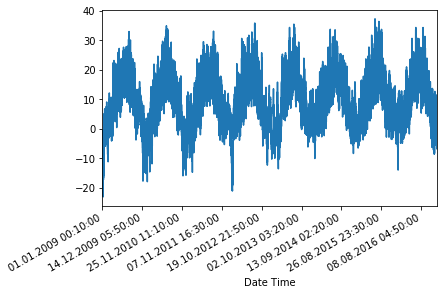

In [8]:
data_univariate.plot(subplots=True)

In [9]:
data_univariate = data_univariate.values
data_univariate_mean = data_univariate[:TRAIN_SPLIT].mean()
data_univariate_std = data_univariate[:TRAIN_SPLIT].std()
data_univariate = (data_univariate-data_univariate_mean)/data_univariate_std

In [10]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(data_univariate, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(data_univariate, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [11]:
print(len(y_val_uni))

120531


In [12]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [13]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [44]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

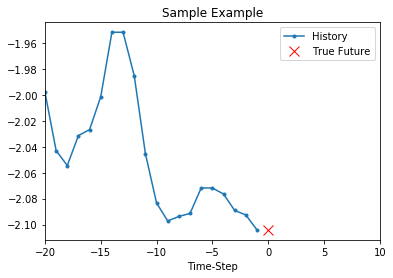

In [45]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [16]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\mubal\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

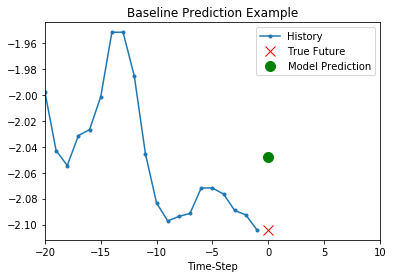

In [17]:
#print(x_train_uni[0])
#print(y_train_uni[0])
#print(baseline(x_train_uni[0]))
#print(x_train_uni.shape[-2:])
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

In [49]:
x_train_uni_list = [x[0] for x in x_train_uni[0].tolist()]
X_train_ssa = pd.Series(x_train_uni_list, name="T (degC)")
print(X_train_ssa)
x_val_uni_list = [x[0] for x in x_val_uni[0].tolist()]
X_val_ssa = pd.Series(x_val_uni_list, name="T (degC)")
print(X_val_ssa)

0    -1.997663
1    -2.042819
2    -2.054397
3    -2.031241
4    -2.026609
5    -2.001136
6    -1.951349
7    -1.951349
8    -1.984927
9    -2.045135
10   -2.083344
11   -2.097238
12   -2.093764
13   -2.091449
14   -2.071765
15   -2.071765
16   -2.076397
17   -2.089133
18   -2.092606
19   -2.104185
Name: T (degC), dtype: float64
0     0.642228
1     0.636439
2     0.636439
3     0.636439
4     0.636439
5     0.636439
6     0.636439
7     0.636439
8     0.631807
9     0.629492
10    0.629492
11    0.626018
12    0.621387
13    0.619071
14    0.613282
15    0.607493
16    0.606335
17    0.604019
18    0.600546
19    0.600546
Name: T (degC), dtype: float64


In [50]:
pipeline = Pipeline([
    SsaForecaster(series_length=6,
                  train_size=20,
                  window_size=3,
                  horizon=3,
                  columns={'T (degC)_fc': 'T (degC)'})
])

In [51]:
pipeline.fit(X_train_ssa)
print(X_train_ssa)

Elapsed time: 00:00:00.0358124
0    -1.997663
1    -2.042819
2    -2.054397
3    -2.031241
4    -2.026609
5    -2.001136
6    -1.951349
7    -1.951349
8    -1.984927
9    -2.045135
10   -2.083344
11   -2.097238
12   -2.093764
13   -2.091449
14   -2.071765
15   -2.071765
16   -2.076397
17   -2.089133
18   -2.092606
19   -2.104185
Name: T (degC), dtype: float64


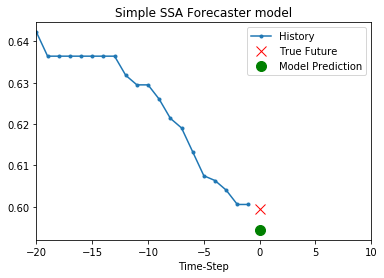


[[0.642228  ]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63180738]
 [0.62949169]
 [0.62949169]
 [0.62601815]
 [0.62138676]
 [0.61907107]
 [0.61328183]
 [0.6074926 ]
 [0.60633475]
 [0.60401906]
 [0.60054552]
 [0.60054552]] 0.5993876681669458 0.594385
    T (degC)  T (degC)_fc.0  T (degC)_fc.1  T (degC)_fc.2
0   0.642228       0.472256       0.746918       0.871203
1   0.636439       1.459838       1.667968       1.755744
2   0.636439       0.544804       0.499621       0.475559
3   0.636439       0.631201       0.625596       0.619337
4   0.636439       0.631012       0.625320       0.619021
5   0.636439       0.631012       0.625320       0.619021
6   0.636439       0.631012       0.625320       0.619021
7   0.636439       0.631012       0.625320       0.619021
8   0.631807       0.626728       0.620577       0.614092
9   0.629492       0.622791       0.616526       0.610011
10  0.629492       0.623532       0.617779       0.6

In [52]:
predicted_val_uni = pipeline.transform(X_val_ssa)
predicted_val = predicted_val_uni['T (degC)_fc.0'][19]
plot = show_plot([x_val_uni[0], y_val_uni[0], predicted_val], 0, 'Simple SSA Forecaster model')
plot.show()
print()
print(x_val_uni[0], y_val_uni[0], predicted_val)
print(predicted_val_uni)

In [ ]:
pipeline.predict()
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(result)